In [1]:
import pyEDM as edm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import RidgeCV
from sklearn.cross_decomposition import PLSCanonical
from sklearn.metrics import mean_squared_error as mse
from IPython.display import clear_output

import os
import time
from typing import Optional, List, Callable, Dict

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch import distributions as D
from torch.distributions.multivariate_normal import MultivariateNormal
# from torchdiffeq import odeint as odeint

from utils.constants import *
from utils.parse_data import *
from utils.ts_alignment import *
from utils.ts_prediction import *
from utils.feature_selection import *
from utils.collect_predictions import *

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('mode.chained_assignment', None)

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 18
plt.rcParams["figure.figsize"] = (12, 7)

### Получение предсказаний (можно пропустить эту часть)

In [3]:
%pycat ts_prediction.py

In [138]:
for SUBDIR in SUBDIRS:
    # parsing data from accelerometer and hyroscope
    dev_filename = f"./signals/{SUBDIR}.json"
    devices_data = parse_devices(dev_filename)
    
    # parsing data from video
    vid_filename = f"./encoded_video/{SUBDIR}.json"
    video_data = parse_video(vid_filename, KEYPOINTS_CNT)
    
    # alignment of time series
    cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
    small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)
    
    libsize = 700 if SUBDIR.startswith("chaotic") else 420
    predsize = 100 if SUBDIR.startswith("chaotic") else 60
    
    # CCM feature extraction and ts prediction
    extra_feat_inds = ccm_feat_selection(libsize=libsize, 
                                         k_feat_to_select=4, 
                                         devices_data=cut_devices_data, 
                                         video_data=video_data, 
                                         save_result=True, 
                                         filename=f"./preds/{SUBDIR}/ccm/small_corr_mat.txt")
    ccm_predict_ts(small_data, 
                   extra_feat_inds, 
                   libsize, 
                   predsize, 
                   Tp=1, 
                   subdir=SUBDIR)

    # PLS feature extraction and ts prediction
    pls_video = pls_feat_selection(libsize, 
                                   k_feat_to_select=4,                                   
                                   devices_data=cut_devices_data, 
                                   video_data=video_data)
    linear_predict_ts(pls_video, 
                      cut_devices_data, 
                      libsize, 
                      predsize, 
                      Tp=1, 
                      subdir=SUBDIR, 
                      latent_mode="pls")

    # CCA feature extraction and ts prediction
    cca_video = cca_feat_selection(libsize, 
                                   k_feat_to_select=4, 
                                   devices_data=cut_devices_data, 
                                   video_data=video_data)
    linear_predict_ts(cca_video, 
                      cut_devices_data, 
                      libsize, 
                      predsize, 
                      Tp=1, 
                      subdir=SUBDIR, 
                      latent_mode="cca")
    
    # Simple ts prediction
    naive_predict_ts(small_data, 
                     libsize, 
                     predsize, 
                     Tp=1, 
                     subdir=SUBDIR)

100%|███████████████████████████████████████████| 52/52 [00:18<00:00,  2.75it/s]


###  Эксперимент 0. Отрисовка исходных данных

Получение данных

In [6]:
SUBDIR = "cyclic_2"

# parsing data from accelerometer and hyroscope
dev_filename = f"./signals/{SUBDIR}.json"
devices_data = parse_devices(dev_filename)

# parsing data from video
vid_filename = f"./encoded_video/{SUBDIR}.json"
video_data = parse_video(vid_filename, KEYPOINTS_CNT)

# alignment of time series
cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)

Отрисовка показаний акселерометра и гироскопа

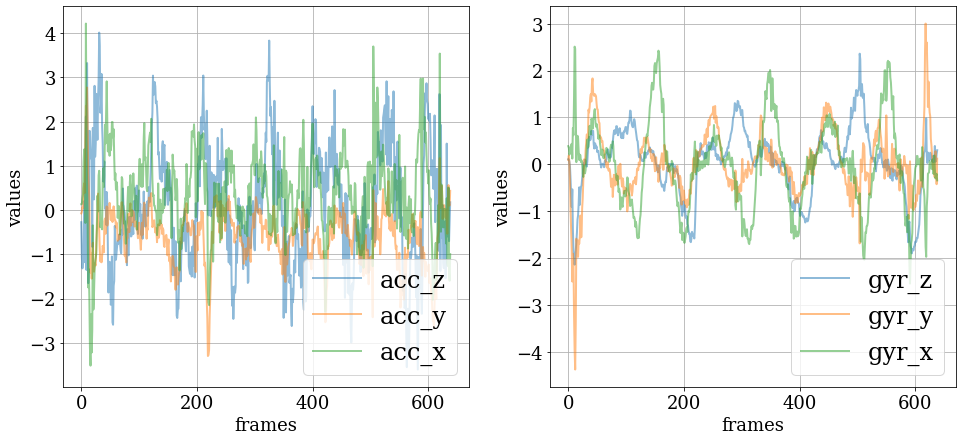

In [8]:
plt.figure(figsize=(16, 7))

for i, target in enumerate(TARGET_COLUMNS):
    if i < 3:
        plt.subplot(121)
    else:        
        plt.subplot(122)
        
    plt.plot(small_data[target].values, alpha=0.5, label=target)
    
    plt.grid(True)
    plt.xlabel("frames")
    plt.ylabel("values")
    plt.legend(loc="lower right")
    
plt.savefig("./images/cyclic_devices_data.png")
plt.show()

Отрисовка кейпоинтов, полученных по видео

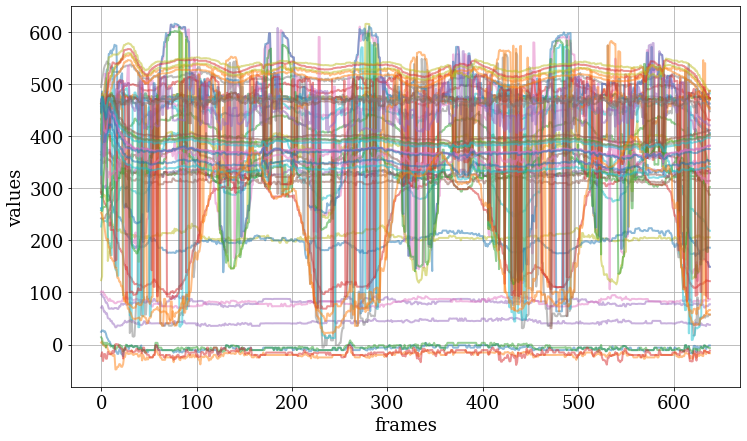

In [20]:
for video_col in VIDEO_COLUMNS:
    plt.plot(small_data[video_col].values, alpha=0.5)
    plt.xlabel("frames")
    plt.ylabel("values")
    
plt.grid(True)
plt.savefig("./images/cyclic_video_data.png")
plt.show()

### Эксперимент 1. Применение предсказательной модели в траекторном пространстве и его подпространстве

Получение предсказаний в траекторном пространстве

In [61]:
def wmape(preds, target):
    assert preds.shape == target.shape
    
    return np.sum(np.abs(preds - target), axis=0) / np.sum(np.abs(target), axis=0)

def tracking_signal(preds, targets, beta=0.07):
    assert preds.shape == targets.shape
    
    errors = targets - preds
    coeff_col = np.array([beta*(1-beta)**i for i in range(preds.shape[0]-1, -1, -1)])
    coeff_col = np.expand_dims(coeff_col, axis=tuple(range(1, targets.ndim)))
    
    error_mean = np.sum(np.multiply(coeff_col, errors), axis=0)
    error_std = np.sum(np.multiply(coeff_col, np.abs(errors)), axis=0)

    return np.divide(error_mean, error_std)

In [62]:
SUBDIR = 'chaotic_2'

# parsing data from accelerometer and hyroscope
dev_filename = f"./signals/{SUBDIR}.json"
devices_data = parse_devices(dev_filename)

# parsing data from video
vid_filename = f"./encoded_video/{SUBDIR}.json"
video_data = parse_video(vid_filename, KEYPOINTS_CNT)

# alignment of time series
cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)

libsize = 700 if SUBDIR.startswith("chaotic") else 420
predsize = 100 if SUBDIR.startswith("chaotic") else 60

extra_feat_inds = np.repeat(np.arange(video_data.shape[1])[None, :], 
                            TARGET_SIZE, 
                            axis=0)

ccm_predict_ts(small_data, 
               extra_feat_inds,
               libsize, 
               predsize, 
               Tp=1, 
               subdir=SUBDIR)

space_preds = collect_pred_from_diff_targets(SUBDIR, "ccm")
targets = space_preds.values[:, range(0, 11, 2)]
space_values = space_preds.values[:, range(1, 12, 2)]

Получение предскаазний в траекторном подпространстве

In [63]:
extra_feat_inds = ccm_feat_selection(libsize=libsize, 
                                     k_feat_to_select=4, 
                                     devices_data=cut_devices_data, 
                                     video_data=video_data, 
                                     read_result=True, 
                                     filename=f"./preds/{SUBDIR}/ccm/small_corr_mat.txt")

ccm_predict_ts(small_data, 
               extra_feat_inds,
               libsize, 
               predsize, 
               Tp=1, 
               subdir=SUBDIR)

subspace_preds = collect_pred_from_diff_targets(SUBDIR, "ccm")
subspace_values = subspace_preds.values[:, range(1, 12, 2)]

Сравнение полученных результатов

In [64]:
tracking_signal(space_values, targets)

array([ 0.84891346, -0.98501323, -0.64908218, -0.91027481, -0.94009998,
        0.93683818])

In [65]:
tracking_signal(subspace_values, targets)

array([ 0.68761884, -0.95671779, -0.92533719, -0.98347643, -0.98890638,
        0.61295305])

In [67]:
space_mse = mse(space_values, targets, multioutput='raw_values')
subspace_mse = mse(subspace_values, targets, multioutput='raw_values')

space_std_err = np.square(space_values - targets).std(axis=0)
subspace_std_err = np.square(subspace_values - targets).std(axis=0)

space_wmape = wmape(space_values, targets)
subspace_wmape = wmape(subspace_values, targets)

errors_data = np.concatenate([space_mse, 
                              space_std_err,
                              subspace_mse,  
                              subspace_std_err,
                              space_wmape, 
                              subspace_wmape]).reshape(6, -1)
errors = pd.DataFrame(data=errors_data, 
                      index=['space_mse', 'space_std', 'subspace_mse', 
                             'subspace_std', 'space_wmape', 'subspace_wmape'],
                      columns=TARGET_COLUMNS)

errors.applymap(lambda val: round(val, 3))

,acc_z,acc_y,acc_x,gyr_z,gyr_y,gyr_x
space_mse,1.053,0.401,0.483,0.084,0.090,0.063
space_std,2.223,0.833,0.825,0.537,0.094,0.295
subspace_mse,0.315,0.043,0.150,0.001,0.015,0.001
subspace_std,0.461,0.051,0.177,0.001,0.031,0.003
space_wmape,0.833,0.923,0.765,0.201,0.609,0.224
subspace_wmape,0.487,0.342,0.458,0.058,0.226,0.042


### Эксперимент 2. Сравнение методов снижения размерности

Получение таблицы "метод / целевой признак"

In [13]:
SUBDIR = 'chaotic_2'
res_columns = TARGET_COLUMNS
res_indices = PRED_METHODS
result_data = np.array([])

for TARGET in TARGET_COLUMNS:
    values = collect_pred_from_diff_methods(SUBDIR, TARGET).values
    targets = np.tile(values[:, 0].reshape(-1, 1), (1, len(PRED_METHODS)))
    values = values[:, 1:]
    
    target_mse = mse(values, targets, multioutput='raw_values')
    errors_std = np.square(values - targets).std(axis=0)
    
    result_data = np.append(result_data, target_mse)
    result_data = np.append(result_data, errors_std)
    
result_data = result_data.reshape(-1, len(PRED_METHODS))
table = pd.DataFrame(data=result_data, 
                     index=np.ravel([[target, f"{target}_std"] for target in TARGET_COLUMNS]), 
                     columns=PRED_METHODS)

table.applymap(lambda val: round(val, 3))

,ccm,pls,cca,naive
acc_z,0.315,0.416,0.416,0.331
acc_z_std,0.461,1.330,0.617,0.439
acc_y,0.043,0.045,0.429,0.055
acc_y_std,0.051,0.058,0.595,0.089
acc_x,0.150,0.177,0.221,0.143
acc_x_std,0.177,0.403,0.245,0.184
gyr_z,0.001,0.002,0.003,0.003
gyr_z_std,0.001,0.007,0.005,0.007
gyr_y,0.015,0.022,0.061,0.026
gyr_y_std,0.031,0.092,0.086,0.047


Отрисовка предсказаний временного ряда

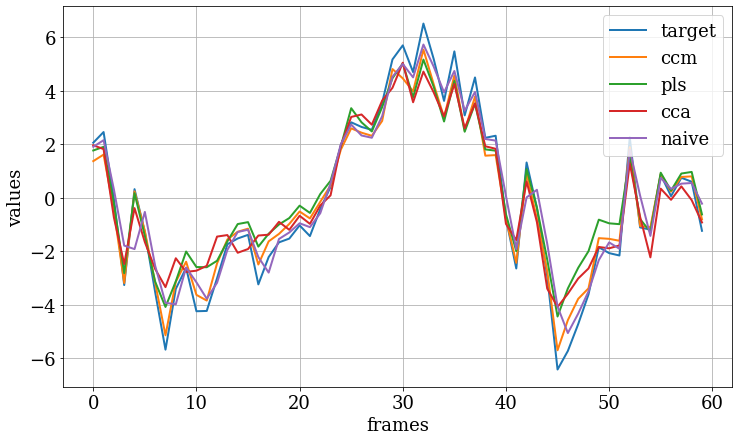

In [70]:
SUBDIR = 'round_and_round'
TARGET = 'acc_z'
preds = collect_pred_from_diff_methods(SUBDIR, TARGET)

for column in preds.columns:
    plt.plot(preds[column].values, label=column)

plt.xlabel("frames")
plt.ylabel("values")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("./images/predictions.png")
plt.show()

### Эксперимент 3. Сравнение качества предсказания от роста обучающей выборки

### Отрисовка графиков с презентации

In [93]:
SUBDIR = "cyclic_2"
main_target_ind = 5
main_target = TARGET_COLUMNS[main_target_ind]
# parsing data from accelerometer and hyroscope
dev_filename = f"./signals/{SUBDIR}.json"
devices_data = parse_devices(dev_filename)

# parsing data from video
vid_filename = f"./encoded_video/{SUBDIR}.json"
video_data = parse_video(vid_filename, KEYPOINTS_CNT)

# alignment of time series
cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)

libsize = 700 if SUBDIR.startswith("chaotic") else 420
predsize = 100 if SUBDIR.startswith("chaotic") else 60

# CCM feature extraction and ts prediction
extra_feat_inds = ccm_feat_selection(libsize=libsize, 
                                     k_feat_to_select=4, 
                                     devices_data=cut_devices_data, 
                                     video_data=video_data, 
                                     read_result=True, 
                                     filename=f"./preds/{SUBDIR}/ccm/small_corr_mat.txt")

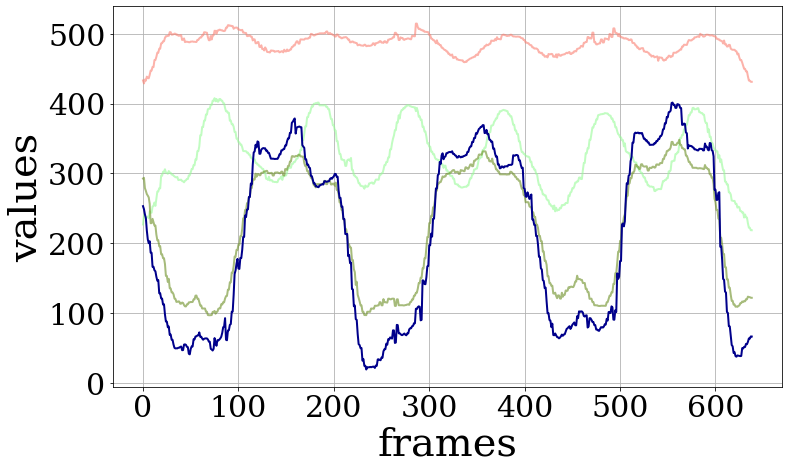

In [94]:
plt.figure()

colors = ("salmon", "palegreen", "olivedrab", "darkblue")

for ind, color in zip(extra_feat_inds[main_target_ind], colors):
    alpha = 1 if color == "darkblue" else 0.6
    
    plt.plot(video_data.iloc[:, ind].values, 
             label=video_data.columns[ind], 
             color=color,
             alpha=alpha)
    
plt.grid(True)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("frames", fontsize=40)
plt.ylabel("values", fontsize=40)
plt.savefig("images/source_ts_example.png")

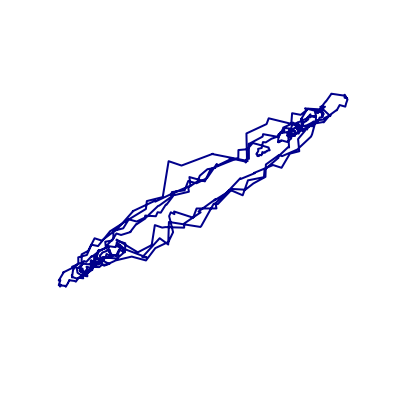

In [99]:
embed_source = edm.Embed(dataFrame=video_data.iloc[:, :], 
                         columns=video_data.columns[extra_feat_inds[main_target_ind, 3]], 
                         tau=-2,
                         E=3)

ax = plt.subplot(projection='3d')
ax.plot(embed_source.iloc[:, 0].values,
        embed_source.iloc[:, 1].values, 
        embed_source.iloc[:, 2].values, 
        color=colors[-1])

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Remove ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])

# Remove axis
ax.set_axis_off()

# Bonus: To get rid of the grid as well:
ax.grid(False)

plt.savefig("images/3d_source.png")

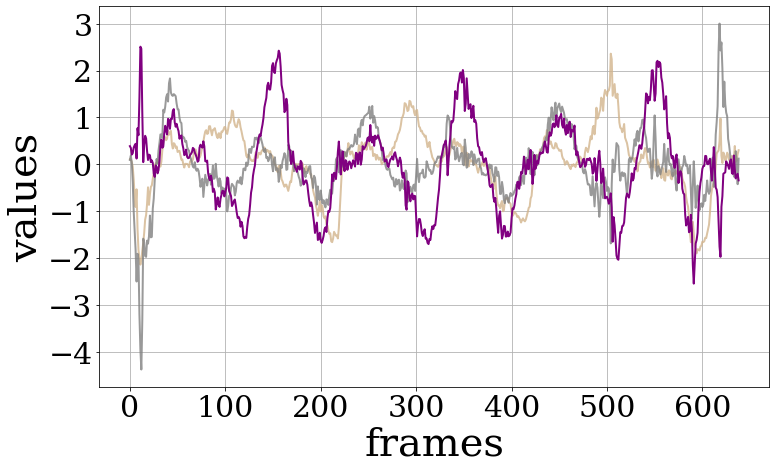

In [103]:
plt.figure()

colors = ("tan", "gray", "purple")

for target, color in zip(TARGET_COLUMNS[3:], colors):
    alpha = 1 if target == main_target else 0.8
    
    plt.plot(cut_devices_data[target].values, 
             color=color, 
             label=target, 
             alpha=alpha)

plt.grid(True)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("frames", fontsize=40)
plt.ylabel("values", fontsize=40)
plt.savefig("images/target_ts_example.png")

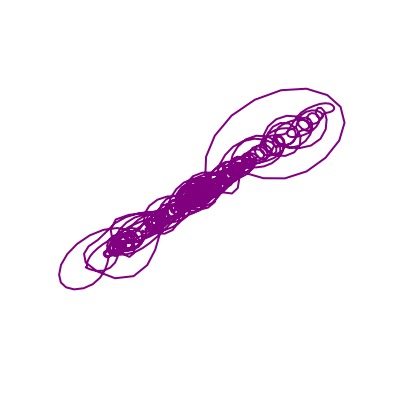

In [108]:
embed_target = edm.Embed(dataFrame=devices_data.iloc[:, :], 
                         columns=[main_target], 
                         tau=-2,
                         E=3)

ax = plt.subplot(projection='3d')

ax.plot(embed_target.iloc[:, 0].values,
        embed_target.iloc[:, 1].values, 
        embed_target.iloc[:, 2].values, 
        color=colors[2])

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Remove ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])

# Remove axis
ax.set_axis_off()

ax.grid(False)

plt.savefig("images/3d_target.png")